In [9]:
%cd C:\Users\Raivo Koot\Desktop\YOLOTensorflow

C:\Users\Raivo Koot\Desktop\YOLOTensorflow


In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
from YOLO.src.helper_functions.load_TFRecords import get_dataset
from YOLO.src.classes.Losses import YOLOConfidenceLoss, YOLOBoxLoss, YOLOClassLoss

import YOLO.GlobalValues as GlobalValues
GlobalValues.initialize()

In [12]:
train_filenames = ['train-000-of-010.tfrecord', 
                   'train-001-of-010.tfrecord',
                   'train-002-of-010.tfrecord',
                   'train-003-of-010.tfrecord',
                   'train-004-of-010.tfrecord',
                   'train-005-of-010.tfrecord',
                   'train-006-of-010.tfrecord',
                   'train-007-of-010.tfrecord',
                   'train-008-of-010.tfrecord',
                   'train-009-of-010.tfrecord',]

val_filenames = ['val-000-of-010.tfrecord', 
                 'val-001-of-010.tfrecord',
                 'val-002-of-010.tfrecord',
                 'val-003-of-010.tfrecord',
                 'val-004-of-010.tfrecord',
                 'val-005-of-010.tfrecord',
                 'val-006-of-010.tfrecord',
                 'val-007-of-010.tfrecord',
                 'val-008-of-010.tfrecord',
                 'val-009-of-010.tfrecord',]

train = get_dataset(train_filenames, augmentation=True)
#val = get_dataset(val_filenames)

# MobileNetV2 Overall Architecture
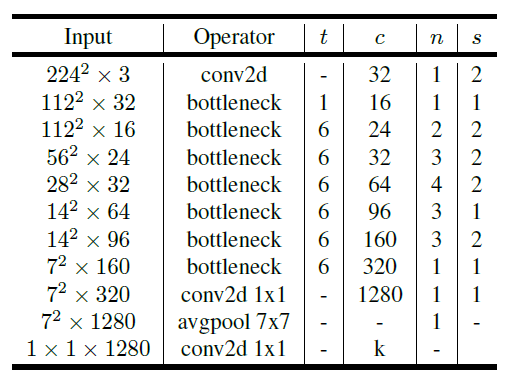

### We will use MobileNetV2 as our base feature extractor because it is fast (we need this for real-time object detection) and if we remove the last two layers it's output will have shape (7\*7\*1280). This way we are left with spatial information in a (7\*7) grid which is exactly the spatial output shape we want our YOLO model to have.
### We will add a few trainable Convolution Layers ontop of this base model.

In [12]:
INPUT_SHAPE = GlobalValues.FEATURE_EXTRACTOR_INPUT_SHAPE

base_model = GlobalValues.FEATURE_EXTRACTOR(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)

for layer in base_model.layers:
    layer.trainable = False

print(base_model.layers[-1].output_shape)

(None, 7, 7, 1280)


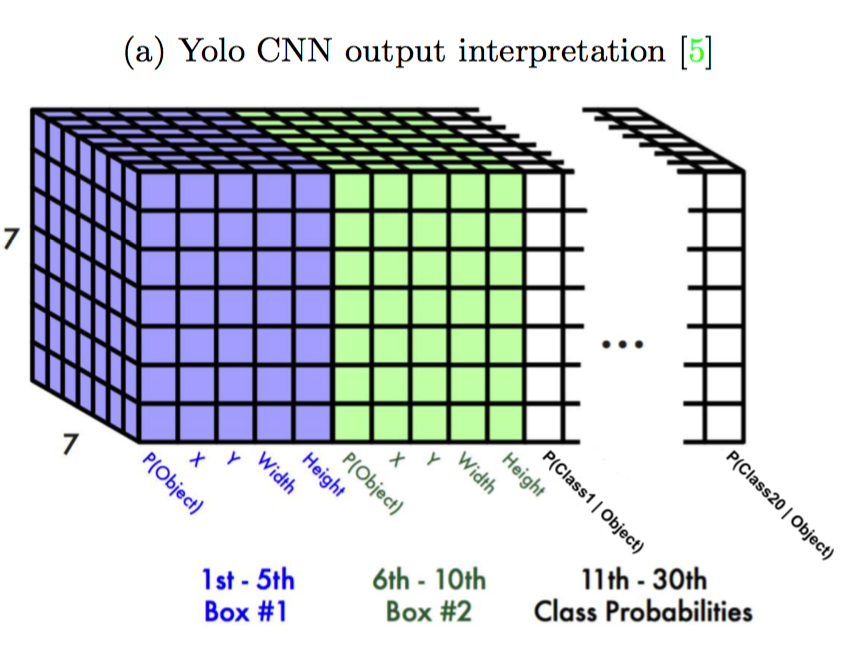
## As you can see in the above image of the YOLO output tensor, the colored parts are bounding box predictions. Every cell of the bounding box predictions should have a value between 0 and 1 (Sigmoid in our model). 
## On the other hand, the white colored parts of the tensor are the class predictions which need to be probability distributions (softmax in our model).

In [13]:
S = GlobalValues.S
CLASSES = GlobalValues.CLASSES
BOXES = GlobalValues.B

conv_1 = tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', 
                                kernel_regularizer=tf.keras.regularizers.l2(0.01))(base_model.output)
batchnorm_1 = tf.keras.layers.BatchNormalization()(conv_1)
activation_1 = tf.keras.layers.Activation('relu')(batchnorm_1)

# OUTPUT LAYERS
confidence_output = tf.keras.layers.Conv2D(BOXES, kernel_size=(1,1), padding='same', activation='sigmoid')(activation_1)
xy_output = tf.keras.layers.Conv2D(BOXES*2, kernel_size=(1,1), padding='same', activation='sigmoid')(activation_1)
wh_output = tf.keras.layers.Conv2D(BOXES*2, kernel_size=(1,1), padding='same', activation='tanh')(activation_1)

class_output_layers = []
for _ in range(BOXES):
    class_output_layers.append(tf.keras.layers.Conv2D(CLASSES, kernel_size=(1,1), padding='same', activation='softmax')(activation_1))

output_layers = [confidence_output, xy_output, wh_output] + class_output_layers

output = tf.keras.layers.Concatenate(axis=3)(output_layers)
model = tf.keras.Model(inputs=base_model.input, outputs=output)


In [14]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

Total params: 2,628,632
Trainable params: 370,584
Non-trainable params: 2,258,048
__________________________________________________________________________________________________


# Define Callbacks 

In [16]:
checkpoint_filepath = 'model_checkpoints/MobileNet-Conv32L2001-(10-05-5).epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_freq='epoch',
    save_best_only=True,
    save_weights_only=True)


import datetime
log_dir = "model_checkpoints/logs/fit/" + datetime.datetime.now().strftime("MobileNet-Conv32L2001-(10-05-5)")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=(1,5))

earlystopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

# Train

In [18]:
SCALE_FACTOR_BOUNDINGBOX = GlobalValues.SCALE_FACTOR_BOUNDINGBOX
SCALE_FACTOR_NOOBJECT_CONFIDENCE = GlobalValues.SCALE_FACTOR_NOOBJECT_CONFIDENCE
SCALE_FACTOR_OBJECT_CONFIDENCE = GlobalValues.SCALE_FACTOR_OBJECT_CONFIDENCE

# LOSS
loss_1 = YOLOConfidenceLoss(BOXES, SCALE_FACTOR_NOOBJECT_CONFIDENCE)
loss_2 = YOLOBoxLoss(BOXES, SCALE_FACTOR_BOUNDINGBOX)
loss_3 = YOLOClassLoss(BOXES, CLASSES)

# COMPILE
model.compile(loss=[loss_1, loss_2, loss_3], 
              optimizer=tf.keras.optimizers.Adam(0.001))

# TRAIN
history = model.fit(train, epochs=30, validation_data=(val),
                   callbacks=[tensorboard, earlystopping, model_checkpoint_callback])

Epoch 1/30
191/191 [==============================] - 354s 2s/step - loss: 2132.6328 - val_loss: 778.6240
Epoch 2/30
191/191 [==============================] - 328s 2s/step - loss: 503.2332 - val_loss: 408.9194
Epoch 3/30
191/191 [==============================] - 340s 2s/step - loss: 301.8352 - val_loss: 316.5462
Epoch 4/30
191/191 [==============================] - 366s 2s/step - loss: 239.7107 - val_loss: 298.4053
Epoch 5/30
191/191 [==============================] - 385s 2s/step - loss: 204.3719 - val_loss: 291.8652
Epoch 6/30
191/191 [==============================] - 419s 2s/step - loss: 178.9987 - val_loss: 296.8646
Epoch 7/30
191/191 [==============================] - ETA: 0s - loss: 159.1313

KeyboardInterrupt: 

# Helper function

In [ ]:
tf.profiler.experimental.stop(
    save=True
)